In [11]:
import pandas as pd #version '0.18.1'
import geopandas as gpd #version '0.3.0'
import numpy as np #version '0.3.0'
import matplotlib.pyplot as plt #version '2.1.0'
import shapely # version '1.5.15'
from fiona.crs import from_epsg # version '1.7.9'
import fiona # version '1.7.9'
import scipy.stats as sp
import statsmodels.api as sm # version '0.6.1'
import seaborn as sns # version '0.7.1'

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In this notebook we try and assess if there is a correlation between demographics in an area and the time taken to close the complaint.

In [12]:
census_df = gpd.GeoDataFrame.from_file('nyc_census_clipped.shp')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


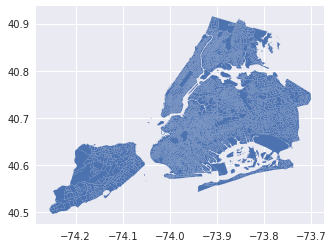

In [13]:
census_df.plot()

In [14]:
census_df.columns

Index(['OBJECTID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'GEOID_Data', 'Shape_Leng', 'Shape_Area', 'Majority_r',
       'GEOID_1', 'B02001e1', 'B02001m1', 'B02001e2', 'B02001m2', 'B02001e3',
       'B02001m3', 'B02001e4', 'B02001m4', 'B02001e5', 'B02001m5', 'B02001e6',
       'B02001m6', 'B02001e7', 'B02001m7', 'B02001e8', 'B02001m8', 'B02001e9',
       'B02001m9', 'B02001e10', 'B02001m10', 'B02008e1', 'B02008m1',
       'B02009e1', 'B02009m1', 'B02010e1', 'B02010m1', 'B02011e1', 'B02011m1',
       'B02012e1', 'B02012m1', 'B02013e1', 'B02013m1', 'C02003e1', 'C02003m1',
       'C02003e2', 'C02003m2', 'C02003e3', 'C02003m3', 'C02003e4', 'C02003m4',
       'C02003e5', 'C02003m5', 'C02003e6', 'C02003m6', 'C02003e7', 'C02003m7',
       'C02003e8', 'C02003m8', 'C02003e9', 'C02003m9', 'C02003e10',
       'C02003m10', 'C02003e11', 'C02003m11', 'C02003e12', 'C02003m12',
       'C02003e13',

In [15]:
census_df = census_df[['OBJECTID','B02001e1','B02001e2', 'B02001e3',
        'B02001e4',  'B02001e5', 'B02001e6','geometry']]
census_df.rename(columns={'B02001e1':'total_population','B02001e2':'white_population', 'B02001e3':'african_american_population',
        'B02001e4':'american_indian_population',  'B02001e5':'asian_population', 'B02001e6':'native_hawaiian_population'},\
                 inplace=True)

We decided to use only these features for this study.

In [16]:
df = pd.read_csv("2018_dep_311.csv")
noise_df = df[df['Complaint Type']=='Noise']
noise_df['Created Date'] = pd.to_datetime(noise_df['Created Date'])
noise_df['Closed Date'] = pd.to_datetime(noise_df['Closed Date'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
noise_df_closed = noise_df[noise_df['Status']=='Closed']
noise_df_open = noise_df[noise_df['Status']=='Open']

In [18]:
noise_df_closed.shape

(60493, 41)

In [19]:
noise_df_open.shape

(169, 41)

In [20]:
noise_df_closed['lag'] = (noise_df_closed['Closed Date']-noise_df_closed['Created Date']).dt.days

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


This field is the number of days taken to close a complaint.

In [21]:
noise_df_closed.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'lag'],
      dtype='object')

In [22]:
noise_df_closed_points = noise_df_closed[['Unique Key','Latitude', 'Longitude','lag']]
noise_df_open_points = noise_df_open[['Unique Key','Latitude', 'Longitude']]

In [23]:
noise_df_open_points.head()

,Unique Key,Latitude,Longitude
2747,38869562,40.779623,-73.979975
5983,39052701,40.776075,-73.955464
6041,39070635,40.867223,-73.925582
6412,38739351,40.830376,-73.948027
6521,38810392,40.765620,-73.983665


Now we convert this dataframe into a shapefile using shapely and geopandas.

In [24]:
noise_df_closed_points['lonlat'] = list(zip(noise_df_closed_points.Longitude, noise_df_closed_points.Latitude))
noise_df_open_points['lonlat'] = list(zip(noise_df_open_points.Longitude, noise_df_open_points.Latitude))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
noise_df_closed_points['geometry'] = noise_df_closed_points[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
noise_df_open_points['geometry'] = noise_df_open_points[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [251]:
noise_df_closed_points = gpd.GeoDataFrame(noise_df_closed_points)
noise_df_closed_points.crs = from_epsg(4326)
noise_df_open_points = gpd.GeoDataFrame(noise_df_open_points)
noise_df_open_points.crs = from_epsg(4326)

In [252]:
census_df.crs

{'init': 'epsg:4269'}

In [253]:
census_df.to_crs(epsg=2263, inplace=True)
noise_df_closed_points.to_crs(epsg=2263, inplace=True)
noise_df_open_points.to_crs(epsg=2263, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


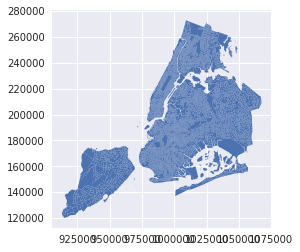

In [254]:
census_df.plot()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(905004.64243583777, 1075872.35755649, 112485.76046193029, 280480.41419764288)

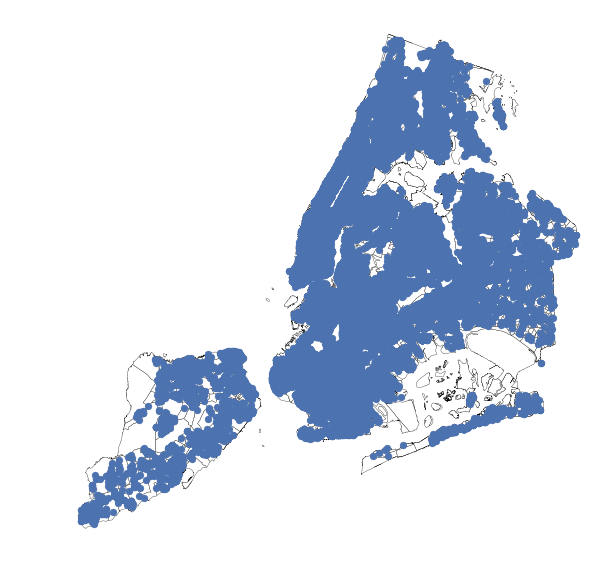

In [255]:
ax = census_df.plot(facecolor="w", edgecolor="k",figsize=(10,10))
noise_df_closed_points.plot(ax=ax)
ax.axis('off')

This figure serves as a sanity check that our data are on the same spatial coordinate frame.

In [256]:
noise_df_closed_points.head()

,Unique Key,Latitude,Longitude,lag,lonlat,geometry
2,40289117,40.722390,-73.809519,0,"(-73.8095188187, 40.7223897657)",POINT (1037048.99996868 202520.0144038592)
16,39351871,40.884868,-73.890804,0,"(-73.8908039575, 40.8848680837)",POINT (1014443.999981992 261678.0144414124)
17,38730897,40.667710,-73.957421,33,"(-73.9574212099, 40.6677099677)",POINT (996061.9999930043 182544.0143909767)
19,39353719,40.735622,-73.959698,0,"(-73.9596980019, 40.735621785)",POINT (995418.9999933734 207286.0144069894)
20,39356684,40.721704,-74.011317,7,"(-74.0113171244, 40.7217041344)",POINT (981113.0000018617 202213.0144037372)


In [257]:
temp_df = gpd.sjoin(census_df, noise_df_closed_points)[["OBJECTID", "lag"]].groupby("OBJECTID").mean()
temp_df2 = gpd.sjoin(census_df, noise_df_closed_points)[["OBJECTID", "Unique Key"]].groupby("OBJECTID").count()

In [258]:
temp_df.reset_index(inplace=True)
temp_df2.reset_index(inplace=True)

In [259]:
temp_df2.rename(columns={'Unique Key':'count'},inplace=True)
temp_df.head()

,OBJECTID,lag
0,1,4.000000
1,2,4.461538
2,3,5.000000
3,4,2.800000
4,5,7.000000


Now we bring in income data from the American Community Survey.

In [260]:
income_df = pd.read_csv('income.csv')

In [261]:
lag_per_blockg_df = census_df.merge(temp_df,on='OBJECTID')
lag_per_blockg_df = lag_per_blockg_df.merge(temp_df2,on='OBJECTID')
lag_per_blockg_df = lag_per_blockg_df.merge(income_df,on='OBJECTID')
lag_per_blockg_df.rename(columns={'B19301e1':'per_capita_income'},inplace=True)

In [262]:
lag_per_blockg_df.head()

,OBJECTID,total_population,white_population,african_american_population,american_indian_population,asian_population,native_hawaiian_population,geometry,lag,count,Unnamed: 0,per_capita_income
0,3,2003.0,171.0,1061.0,33.0,7.0,0.0,"POLYGON ((1010972.515632745 242490.7401744473,...",5.0,3,0,20296.0
1,4,2731.0,124.0,1452.0,0.0,0.0,0.0,"POLYGON ((1010140.320888899 238663.9364475866,...",2.8,10,1,18795.0
2,5,936.0,85.0,414.0,0.0,52.0,0.0,"POLYGON ((1023783.311930013 267023.9250789711,...",7.0,3,2,20516.0
3,6,2935.0,374.0,785.0,0.0,36.0,0.0,"POLYGON ((1014449.751129234 241737.0013949386,...",5.6,5,3,20548.0
4,7,1061.0,195.0,259.0,0.0,65.0,0.0,"POLYGON ((1014159.700771149 239740.0757441526,...",0.0,1,4,27502.0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Total Population')

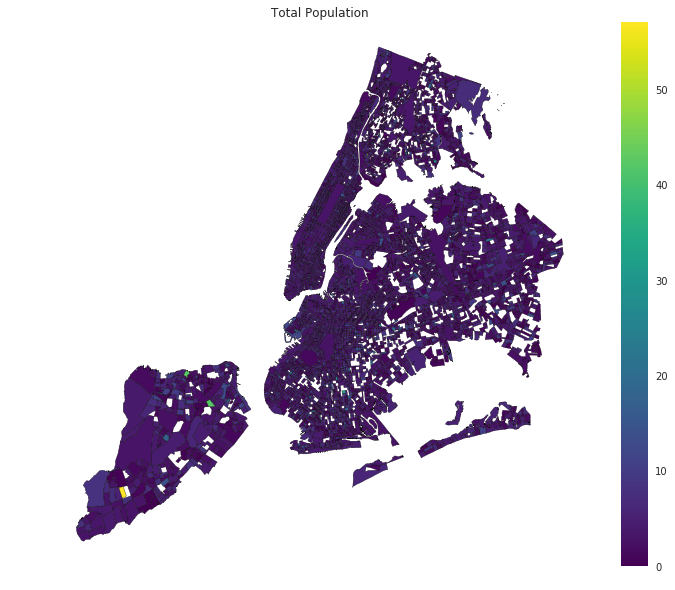

In [290]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(111)
lag_per_blockg_df.plot(column='lag',cmap='viridis', edgecolor="k",ax=ax1,legend=True)
ax1.axis('off')
ax1.set_title("Lag for each census block group")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


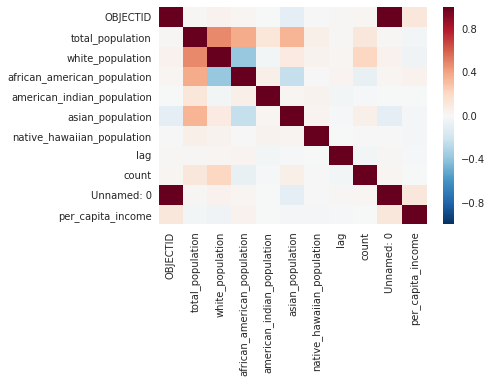

In [265]:
corr = lag_per_blockg_df.corr()
sns.heatmap(corr)

In [266]:
temp_df = gpd.sjoin(census_df, noise_df_open_points)[["OBJECTID", "Unique Key"]].groupby("OBJECTID").count()

In [267]:
temp_df.reset_index(inplace=True)

In [268]:
census_df.head()

,OBJECTID,total_population,white_population,african_american_population,american_indian_population,asian_population,native_hawaiian_population,geometry
index_left,,,,,,,,
0,1,1110.0,164.0,392.0,20.0,0.0,0.0,"POLYGON ((1008052.975734672 241673.0398247156,..."
1,2,1445.0,277.0,584.0,0.0,11.0,0.0,"POLYGON ((1008795.97847896 239804.3687139761, ..."
2,3,2003.0,171.0,1061.0,33.0,7.0,0.0,"POLYGON ((1010972.515632745 242490.7401744473,..."
3,4,2731.0,124.0,1452.0,0.0,0.0,0.0,"POLYGON ((1010140.320888899 238663.9364475866,..."
4,5,936.0,85.0,414.0,0.0,52.0,0.0,"POLYGON ((1023783.311930013 267023.9250789711,..."


In [269]:
open_per_blockg_df = census_df.merge(temp_df,on='OBJECTID')
open_per_blockg_df = census_df.merge(income_df,on='OBJECTID')
open_per_blockg_df.rename(columns={'Unique Key':'Count of open cases','B19301e1':'per_capita_income'},inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


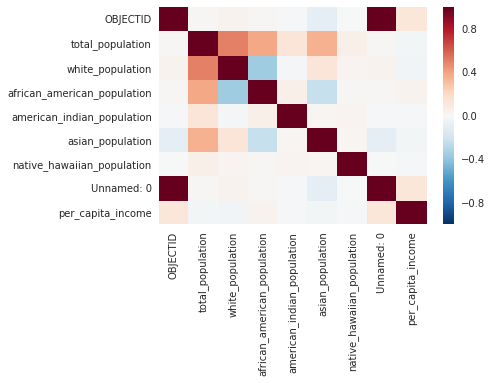

In [270]:
corr = open_per_blockg_df.corr()
sns.heatmap(corr)

In [271]:
open_per_blockg_ratios_df = open_per_blockg_df
open_per_blockg_ratios_df['white_population'] = open_per_blockg_df['white_population']/open_per_blockg_df['total_population']
open_per_blockg_ratios_df['african_american_population'] = open_per_blockg_df['african_american_population']/open_per_blockg_df['total_population']
open_per_blockg_ratios_df['american_indian_population'] = open_per_blockg_df['american_indian_population']/open_per_blockg_df['total_population']
open_per_blockg_ratios_df['asian_population'] = open_per_blockg_df['asian_population']/open_per_blockg_df['total_population']
open_per_blockg_ratios_df['native_hawaiian_population'] = open_per_blockg_df['native_hawaiian_population']/open_per_blockg_df['total_population']

In [272]:
lag_per_blockg_ratios_df = lag_per_blockg_df
lag_per_blockg_ratios_df['white_population'] = lag_per_blockg_df['white_population']/lag_per_blockg_df['total_population']
lag_per_blockg_ratios_df['african_american_population'] = lag_per_blockg_df['african_american_population']/lag_per_blockg_df['total_population']
lag_per_blockg_ratios_df['american_indian_population'] = lag_per_blockg_df['american_indian_population']/lag_per_blockg_df['total_population']
lag_per_blockg_ratios_df['asian_population'] = lag_per_blockg_df['asian_population']/lag_per_blockg_df['total_population']
lag_per_blockg_ratios_df['native_hawaiian_population'] = lag_per_blockg_df['native_hawaiian_population']/lag_per_blockg_df['total_population']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


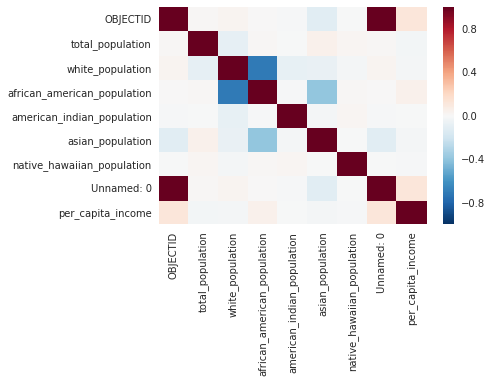

In [273]:
corr = open_per_blockg_ratios_df.corr()
sns.heatmap(corr)

In [282]:
lag_per_blockg_ratios_df.columns

Index(['OBJECTID', 'total_population', 'white_population',
       'african_american_population', 'american_indian_population',
       'asian_population', 'native_hawaiian_population', 'geometry', 'lag',
       'count', 'Unnamed: 0', 'per_capita_income'],
      dtype='object')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


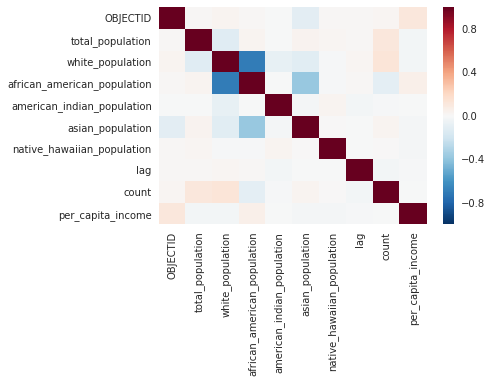

In [286]:
lag_per_blockg_ratios_df.drop(['Unnamed: 0'],axis=1,inplace=True)
corr = lag_per_blockg_ratios_df.corr()
sns.heatmap(corr)

From this covariance matrix we see that the lag variable is not related to any of the other variables.

In [275]:
lag_per_blockg_ratios_df.columns

Index(['OBJECTID', 'total_population', 'white_population',
       'african_american_population', 'american_indian_population',
       'asian_population', 'native_hawaiian_population', 'geometry', 'lag',
       'count', 'Unnamed: 0', 'per_capita_income'],
      dtype='object')

In [278]:
lag_per_blockg_ratios_df.to_file(driver = 'ESRI Shapefile', filename= "lag_results.shp")

In [279]:
col_list = ['total_population', 'white_population',\
       'african_american_population', 'american_indian_population',\
       'asian_population', 'native_hawaiian_population','per_capita_income']
model1 = sm.OLS(lag_per_blockg_ratios_df.dropna()['lag'],lag_per_blockg_ratios_df.dropna()[col_list]).fit()

In [280]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lag   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1261.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:25:26   Log-Likelihood:                -13568.
No. Observations:                5365   AIC:                         2.715e+04
Df Residuals:                    5358   BIC:                         2.720e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
total_population                0.0005   5.71e-05      8.925      0.000         0.000     0.001
white_population                3.3982      0.134     25.383      0.000         3.136     3.661
african_american_population     3.6777      0.174     21.128      0.000         3.336     4.019
american_indian_population      2.9784      2.622      1.136      0.256        -2.161     8.118
asian_population                3.2092      0.241     13.327      0.000         2.737     3.681
native_hawaiian_population      3.1907     11.430      0.279      0.780       -19.217    25.599
per_capita_income            9.795e-06    2.7e-06      3.623      0.000       4.5e-06  1.51e-05
==============================================================================
Omnibus:                     4830.459   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           386154.547
Skew:                           3.979   Prob(JB):                         0.00
Kurtosis:                      43.794   Cond. No.                     8.44e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This result was surprising as we did not see any correlation to other variables. However, we realised this could be because the data was spatially autocorrelated and this is a problem for the OLS model. We ran a Geographically Weighted regression on ArcGIS for the same data which removes the spartial autocorrelation. This model produced an R-squared of 0.01 and shows that there is no strong correlation to these features. This is good as this means there are no biases in terms of race and income in how complaints are closed.